In [1]:
from config import setup_project_path, RAW_DATA_DIR, PROCESSED_DATA_DIR,MODELS_DIR
setup_project_path()

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import  LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from hyperopt import hp
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials
from sklearn.model_selection import cross_val_score

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from datetime import datetime, date, timedelta
import os
import numpy as np
from scipy.stats import lognorm, loguniform, norm
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import cross_validate
import boto3
from io import StringIO
pd.set_option('display.max_columns',100)

/Users/kiprono/envs/ag/lib/python3.13/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
data_dir = "."
models_dir = "."

os.makedirs(data_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

In [4]:
df_train_360 = pd.read_csv(os.path.join(data_dir,'KPIs_data_modelling_train_360_days.csv'))
print(df_train_360.shape)
df_test_360 = pd.read_csv(os.path.join(data_dir,'KPIs_data_modelling_test_360_days.csv'))
print(df_test_360.shape)

(50926, 84)
(8987, 84)


In [5]:
df_train_360 = df_test_360[df_test_360.count_units>5]
df_train_360 = df_train_360[df_train_360.count_units>5]

In [6]:
# a = df_train_360
# a["dev"] = a["frr_450"]-a["frr_360"]

# a.groupby("country").agg(
#     mean_dev = ("dev", "mean")
# )

In [7]:
def feature_engineering(df_train, df_test):
    
    # Creating column for Unlock price
    df_train['unlock_price_usd'] = df_train['upfront_price_usd'] + df_train['total_follow_on_revenue_usd']
    df_test['unlock_price_usd'] = df_test['upfront_price_usd'] + df_test['total_follow_on_revenue_usd']
    
    # Calculating averge unlock and upfront price

    df_train['avg_upfront_price_usd'] = np.round((df_train['upfront_price_usd']/df_train['count_units']),0)
    df_train['avg_unlock_price_usd'] = np.round((df_train['unlock_price_usd']/df_train['count_units']),0)

    df_test['avg_upfront_price_usd'] = np.round((df_test['upfront_price_usd']/df_test['count_units']),0)
    df_test['avg_unlock_price_usd'] = np.round((df_test['unlock_price_usd']/df_test['count_units']),0)
    
    # Removing unnecessary columns
    #cols_to_remove = [col for col in df_train.columns if ('repayment_speed_' in col)]
    cols_to_remove = []
    cols_to_remove.append('upfront_price_usd')
    cols_to_remove.append('unlock_price_usd')

    print('columns to remove: ',cols_to_remove)
    
    df_train.drop(cols_to_remove, axis=1, inplace=True)
    df_test.drop(cols_to_remove, axis=1, inplace=True)
    
    print('Sample from train data------------')
    print(df_train.sample(1))
    
    print('Sample from test data------------')
    print(df_test.sample(1))

    df_train = df_train.reset_index().drop(columns = 'index')
    df_test = df_test.reset_index().drop(columns = 'index')
    
    return df_train, df_test

In [8]:
df_train, df_test = feature_engineering(df_train_360, df_test_360)

columns to remove:  ['upfront_price_usd', 'unlock_price_usd']
Sample from train data------------
                                         accounts_group  count_units  \
1170  2022-01_Kenya_SHS Entry-Level Upgrade_Kisii_Su...            6   

      avg_planned_repayment_days    frr_30    frr_60   frr_90   frr_180  \
1170                         371  0.045238  0.088736  0.13228  0.267289   

       frr_270   frr_360   frr_450  frr_540   frr_630  frr_720  \
1170  0.418407  0.572839  0.614139  0.61826  0.621923  0.62696   

      repayment_speed_30  repayment_speed_60  repayment_speed_90  \
1170              0.7159              0.6094              0.5801   

      repayment_speed_180  repayment_speed_270  repayment_speed_360  \
1170               0.5623                0.579               0.5906   

      repayment_speed_450  repayment_speed_540  repayment_speed_630  \
1170               0.6141               0.6182               0.6219   

      repayment_speed_720  avg_cum_days_disabled_30

In [9]:
x_train = df_train.drop(['accounts_group','count_units','frr_3_years','total_follow_on_revenue_usd',
                       'reg_month','country','product_group','area','primary_product','age_in_months',
                      'actual_fr', 'cohort_age'], axis=1)
y_train = df_train[:]['frr_3_years']

print('shape of the input data: ',x_train.shape)
print('shape of the output data: ',y_train.shape)

x_test = df_test.drop(['accounts_group','count_units','frr_3_years','total_follow_on_revenue_usd',
                       'reg_month','country','product_group','area','primary_product','age_in_months',
                      'actual_fr', 'cohort_age'], axis=1)
y_test = df_test[:]['frr_3_years']

print('shape of the input test data: ',x_test.shape)
print('shape of the output test data: ',y_test.shape)

shape of the input data:  (5726, 73)
shape of the output data:  (5726,)
shape of the input test data:  (8987, 73)
shape of the output test data:  (8987,)


In [10]:
n_estimators = [50,100,150,200,250,350,450,500,1000,1500]

space = {
    'num_leaves': hp.loguniform("num_leaves", np.log(5), np.log(200)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1.5)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 250, 200000, 50),
    'min_child_weight': hp.loguniform('min_child_weight', np.log(0.00001), np.log(1)),
    'min_child_samples': hp.quniform('min_child_samples', 0, 200, 5),
    'n_estimators': hp.choice("n_estimators", n_estimators),
    'max_depth': hp.loguniform('max_depth', np.log(3), np.log(50)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0.001, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0.1, 1),
    'subsample': hp.uniform('subsample', 0.1, 1)
}

def hyperparameter_tuning(space):
    
    model = LGBMRegressor(
        n_estimators=int(space['n_estimators']),
        num_leaves=int(space['num_leaves']),
        learning_rate=space['learning_rate'],
        max_depth=int(space['max_depth']),
        subsample_for_bin=int(space['subsample_for_bin']),
        min_child_weight=space['min_child_weight'],
        min_child_samples=int(space['min_child_samples']),
        colsample_bytree=space['colsample_bytree'],
        reg_alpha=space['reg_alpha'],
        reg_lambda=space['reg_lambda'],
        subsample=space['subsample'],
        objective="quantile",
        alpha=0.5,
        n_jobs=-1,
        verbose=-1,
        random_state=1234
    )

    model.set_params(eval_set=[(x_test, y_test)], eval_metric='quantile')

    score_cv = cross_val_score(model, x_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
    
    return {'loss': -score_cv, 'status': STATUS_OK, 'model': model}

trials = Trials()
best_pos_rmse = fmin(fn=hyperparameter_tuning,
                     space=space,
                     algo=tpe.suggest,
                     max_evals=1,
                     trials=trials)

print(best_pos_rmse)

100%|██████████| 1/1 [00:03<00:00,  3.60s/trial, best loss: 0.03140621464389311]
{'colsample_bytree': 0.9095057559880516, 'learning_rate': 0.15521396399645224, 'max_depth': 11.616763151760603, 'min_child_samples': 45.0, 'min_child_weight': 0.5826046078409655, 'n_estimators': 3, 'num_leaves': 14.426703553740099, 'reg_alpha': 0.25946237083446, 'reg_lambda': 0.22221833135352995, 'subsample': 0.9580540344492547, 'subsample_for_bin': 192100.0}


In [11]:
best_pos_rmse = {'colsample_bytree': 0.48612837789165786,
 'learning_rate': 0.03363666646274133,
 'max_depth': 12.799426554738039,
 'min_child_samples': 60.0,
 'min_child_weight': 0.00013900522166696805,
 'n_estimators': 8,
 'num_leaves': 185.84574102396672,
 'reg_alpha': 0.9211614583138252,
 'reg_lambda': 0.8749195072732266,
 'subsample': 0.21685960679782915,
 'subsample_for_bin': 154800.0}


#getting the best params

int_params = ['max_depth','min_child_samples','num_leaves','subsample_for_bin']
best_pos_rmse_params = {k: int(v) if k in int_params else v for k,v in best_pos_rmse.items()}
best_pos_rmse_params = {k: int(n_estimators[v]) if k == 'n_estimators' else v for k,v in best_pos_rmse_params.items()}
print(best_pos_rmse_params)

{'colsample_bytree': 0.48612837789165786, 'learning_rate': 0.03363666646274133, 'max_depth': 12, 'min_child_samples': 60, 'min_child_weight': 0.00013900522166696805, 'n_estimators': 1000, 'num_leaves': 185, 'reg_alpha': 0.9211614583138252, 'reg_lambda': 0.8749195072732266, 'subsample': 0.21685960679782915, 'subsample_for_bin': 154800}


In [12]:
model_reg_lgbm_qntl_tuned_pos_rmse = LGBMRegressor(alpha=0.5, boosting_type='gbdt', class_weight=None, 
                                                   device_type='cpu', importance_type='split',n_jobs=-1, 
                                                   num_threads=-1, objective='quantile',random_state=1234,
                                                   **best_pos_rmse_params)

model_reg_lgbm_qntl_tuned_pos_rmse.fit(x_train,y_train, eval_set=(x_test,y_test), eval_metric='quantile')

print(model_reg_lgbm_qntl_tuned_pos_rmse.best_iteration_)
print(model_reg_lgbm_qntl_tuned_pos_rmse.best_score_)
print(model_reg_lgbm_qntl_tuned_pos_rmse.get_params)
print(model_reg_lgbm_qntl_tuned_pos_rmse)
#print(math.sqrt(mean_squared_error(y_val,model_reg_lgbm_qntl_tuned_pos_rmse.predict(x_val))))
#print(math.sqrt(mean_squared_error(y_val_oot,model_reg_lgbm_qntl_tuned_pos_rmse.predict(x_val_oot))))

0
defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict({'quantile': 0.014617669628398347})})
<bound method LGBMModel.get_params of LGBMRegressor(alpha=0.5, colsample_bytree=0.48612837789165786,
              device_type='cpu', learning_rate=0.03363666646274133,
              max_depth=12, min_child_samples=60,
              min_child_weight=0.00013900522166696805, n_estimators=1000,
              n_jobs=-1, num_leaves=185, num_threads=-1, objective='quantile',
              random_state=1234, reg_alpha=0.9211614583138252,
              reg_lambda=0.8749195072732266, subsample=0.21685960679782915,
              subsample_for_bin=154800)>
LGBMRegressor(alpha=0.5, colsample_bytree=0.48612837789165786,
              device_type='cpu', learning_rate=0.03363666646274133,
              max_depth=12, min_child_samples=60,
              min_child_weight=0.00013900522166696805, n_estimators=1000,
              n_jobs=-1, num_leaves=185, num_threads=-1, objective='quantile',
   

In [13]:
def save_model(model_name, model):
    model_file_name = "quantile_regression_"+model_name+"_days_"+ str(date.today()) +".txt"
    model.booster_.save_model(os.path.join(models_dir, model_file_name))

save_model('360_'+str(0.5), model_reg_lgbm_qntl_tuned_pos_rmse)

In [14]:
model_reg_lgbm_qntl_tuned_pos_rmse.feature_name_

['avg_planned_repayment_days',
 'frr_30',
 'frr_60',
 'frr_90',
 'frr_180',
 'frr_270',
 'frr_360',
 'frr_450',
 'frr_540',
 'frr_630',
 'frr_720',
 'repayment_speed_30',
 'repayment_speed_60',
 'repayment_speed_90',
 'repayment_speed_180',
 'repayment_speed_270',
 'repayment_speed_360',
 'repayment_speed_450',
 'repayment_speed_540',
 'repayment_speed_630',
 'repayment_speed_720',
 'avg_cum_days_disabled_30',
 'avg_cum_days_disabled_60',
 'avg_cum_days_disabled_90',
 'avg_cum_days_disabled_180',
 'avg_cum_days_disabled_270',
 'avg_cum_days_disabled_360',
 'avg_cum_days_disabled_450',
 'avg_cum_days_disabled_540',
 'avg_cum_days_disabled_630',
 'avg_cum_days_disabled_720',
 'at_risk_rate_30',
 'at_risk_rate_60',
 'at_risk_rate_90',
 'at_risk_rate_180',
 'at_risk_rate_270',
 'at_risk_rate_360',
 'at_risk_rate_450',
 'at_risk_rate_540',
 'at_risk_rate_630',
 'at_risk_rate_720',
 'disabled_gt_two_week_rate_30',
 'disabled_gt_two_week_rate_60',
 'disabled_gt_two_week_rate_90',
 'disabled_g

## Evaluation

In [15]:
df_oov = pd.read_csv("KPIs_data_modelling_oot_validation_360_days.csv")
df_oov['unlock_price_usd'] = df_oov['upfront_price_usd'] + df_oov['total_follow_on_revenue_usd']
df_oov['avg_upfront_price_usd'] = np.round((df_oov['upfront_price_usd']/df_oov['count_units']),0)

df_oov['avg_unlock_price_usd'] = np.round((df_oov['unlock_price_usd']/df_oov['count_units']),0)

# Removing unnecessary columns
#cols_to_remove = [col for col in df_train.columns if ('repayment_speed_' in col)]
cols_to_remove = []
cols_to_remove.append('upfront_price_usd')
cols_to_remove.append('unlock_price_usd')

print('columns to remove: ',cols_to_remove)

df_oov.drop(cols_to_remove, axis=1, inplace=True)

# print('Sample from train data------------')
# print(df_train.sample(1))

# print('Sample from test data------------')
# print(df_test.sample(1))

df_oov = df_oov.reset_index().drop(columns = 'index')

columns to remove:  ['upfront_price_usd', 'unlock_price_usd']


In [16]:
x_val = df_oov.drop(['accounts_group','count_units','frr_3_years','total_follow_on_revenue_usd',
                       'reg_month','country','product_group','area','primary_product','age_in_months',
                      'actual_fr', 'cohort_age'], axis=1)
y_val = df_oov[:]['frr_3_years']

In [17]:
preds = model_reg_lgbm_qntl_tuned_pos_rmse.predict(x_val[model_reg_lgbm_qntl_tuned_pos_rmse.feature_name_])
df_oov["predictions"] = preds

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_pinball_loss
results = {
    "rmse": math.sqrt(mean_squared_error(y_val,preds)),
    "mae": mean_absolute_error(y_val, preds),
    "mape": np.mean(np.abs((y_val - preds) / y_val)),
    "r2": r2_score(y_val, preds),
    "qloss":  mean_pinball_loss(y_val, preds, alpha=0.5)
}

results

{'rmse': 0.06757742145193824,
 'mae': 0.033781935190022844,
 'mape': 0.21709300915492233,
 'r2': 0.830089117299144,
 'qloss': 0.016890967595011422}

In [19]:
df_oov[["frr_3_years", "predictions"]].sample(n=10)

,frr_3_years,predictions
16947,0.538462,0.655383
15662,0.946947,0.915825
19525,0.858043,0.862969
3719,0.944015,0.919088
8081,0.899178,0.891930
2846,0.845035,0.858562
19932,0.653667,0.648078
15521,0.944992,0.928599
9251,0.831773,0.830824
4298,0.838018,0.880479


In [20]:
model_reg_lgbm_qntl_tuned_pos_rmse.feature_name_

['avg_planned_repayment_days',
 'frr_30',
 'frr_60',
 'frr_90',
 'frr_180',
 'frr_270',
 'frr_360',
 'frr_450',
 'frr_540',
 'frr_630',
 'frr_720',
 'repayment_speed_30',
 'repayment_speed_60',
 'repayment_speed_90',
 'repayment_speed_180',
 'repayment_speed_270',
 'repayment_speed_360',
 'repayment_speed_450',
 'repayment_speed_540',
 'repayment_speed_630',
 'repayment_speed_720',
 'avg_cum_days_disabled_30',
 'avg_cum_days_disabled_60',
 'avg_cum_days_disabled_90',
 'avg_cum_days_disabled_180',
 'avg_cum_days_disabled_270',
 'avg_cum_days_disabled_360',
 'avg_cum_days_disabled_450',
 'avg_cum_days_disabled_540',
 'avg_cum_days_disabled_630',
 'avg_cum_days_disabled_720',
 'at_risk_rate_30',
 'at_risk_rate_60',
 'at_risk_rate_90',
 'at_risk_rate_180',
 'at_risk_rate_270',
 'at_risk_rate_360',
 'at_risk_rate_450',
 'at_risk_rate_540',
 'at_risk_rate_630',
 'at_risk_rate_720',
 'disabled_gt_two_week_rate_30',
 'disabled_gt_two_week_rate_60',
 'disabled_gt_two_week_rate_90',
 'disabled_g

## Inference

In [21]:
def generate_predictions(df_kpi, date_uploaded, model_object, backtesting_limit=360):
    df_kpi = df_kpi[df_kpi['backtesting_limit'] == backtesting_limit].reset_index().drop(columns = 'index')
    col_720 = [col for col in df_kpi.columns if '_720' in col]
    col_630 = [col for col in df_kpi.columns if '_630' in col]
    col_540 = [col for col in df_kpi.columns if '_540' in col]
    col_450 = [col for col in df_kpi.columns if '_450' in col]

    col_450_540_630_720 = col_720+col_630+col_540+col_450
    col_540_630_720 = col_720+col_630+col_540
    col_630_720 = col_720+col_630

    df_kpi.loc[(df_kpi['cohort_age_backtesting']==360),col_450_540_630_720] = np.nan
    df_kpi.loc[(df_kpi['cohort_age_backtesting']==450),col_540_630_720] = np.nan
    df_kpi.loc[(df_kpi['cohort_age_backtesting']==540),col_630_720] = np.nan
    df_kpi.loc[(df_kpi['cohort_age_backtesting']==630),col_720] = np.nan
    
    preds = model_object.predict(df_kpi[model_object.feature_name_])
    df_kpi["predictions"] = preds
    
    for months in [360, 450, 540, 630, 720]:
        frr_col = f"frr_{months}"
        mask = (df_kpi["age_in_months"] == months) & (df_kpi[frr_col] > df_kpi["predictions"])
        df_kpi.loc[mask, "predictions"] = df_kpi[frr_col]

    df_kpi["predictions"] = df_kpi["predictions"].clip(lower=0, upper=1)
    df_kpi["date_uploaded"] = date_uploaded
    df_kpi["date_uploaded"] = pd.to_datetime(df_kpi["date_uploaded"], format="%Y-%m-%d")
    df_kpi["reg_month"] = pd.to_datetime(df_kpi["reg_month"], format="%Y-%m")
    df_kpi["predicted_revenue_3_years_50"] = np.round(df_kpi['predictions']*df_kpi['total_follow_on_revenue_current_usd'],2)
    return df_kpi


In [22]:
kpi_processed_file = '../../data/KPIs_data_processed_2025-09-01.csv'
df_kpi = pd.read_csv(kpi_processed_file)
df_preds_sep = generate_predictions(df_kpi=df_kpi, date_uploaded="2025-09-01", model_object=model_reg_lgbm_qntl_tuned_pos_rmse, backtesting_limit=360)

kpi_processed_file = '../../data/KPIs_data_processed_2025-08-01.csv'
df_kpi = pd.read_csv(kpi_processed_file)
df_preds_aug = generate_predictions(df_kpi=df_kpi, date_uploaded="2025-08-01", model_object=model_reg_lgbm_qntl_tuned_pos_rmse, backtesting_limit=360)

df = pd.concat([df_preds_sep, df_preds_aug])
print(df.shape)

(332439, 92)


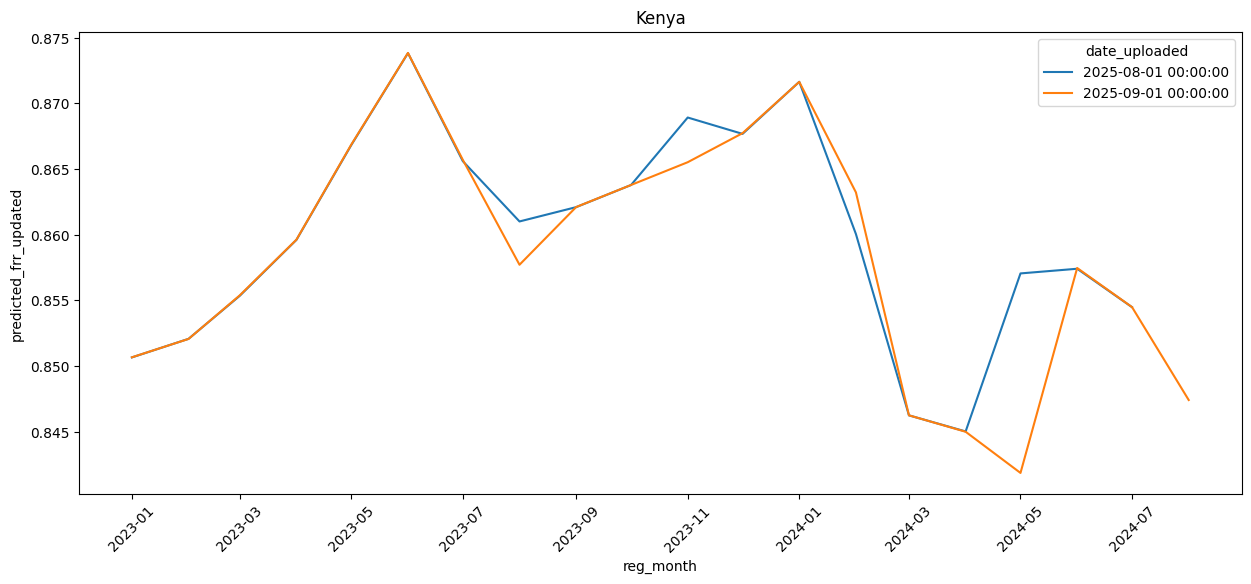

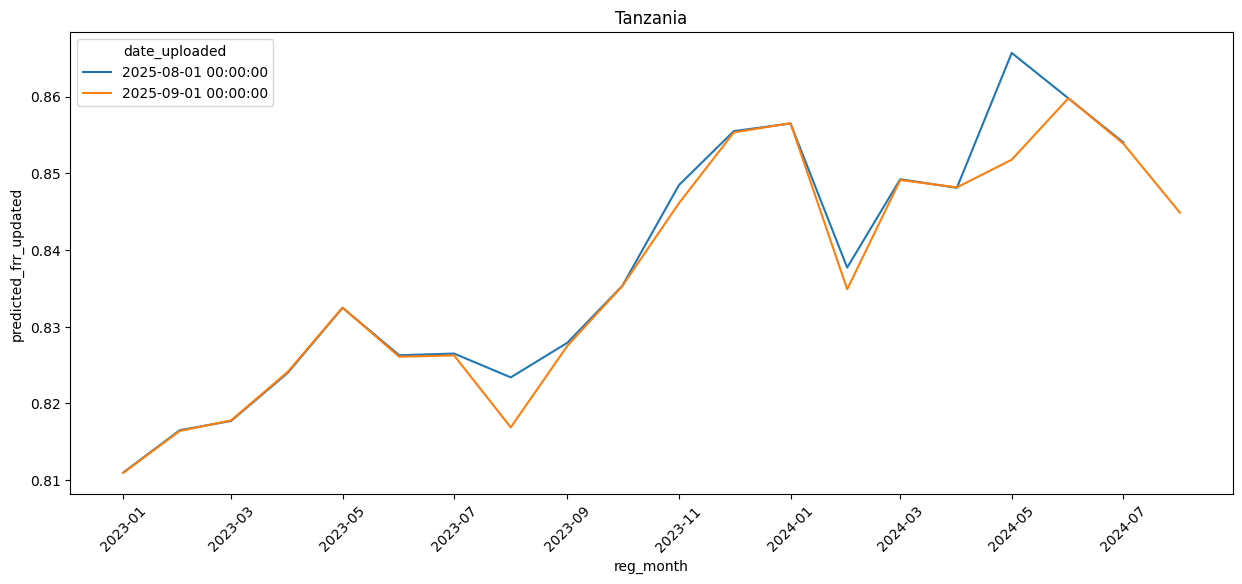

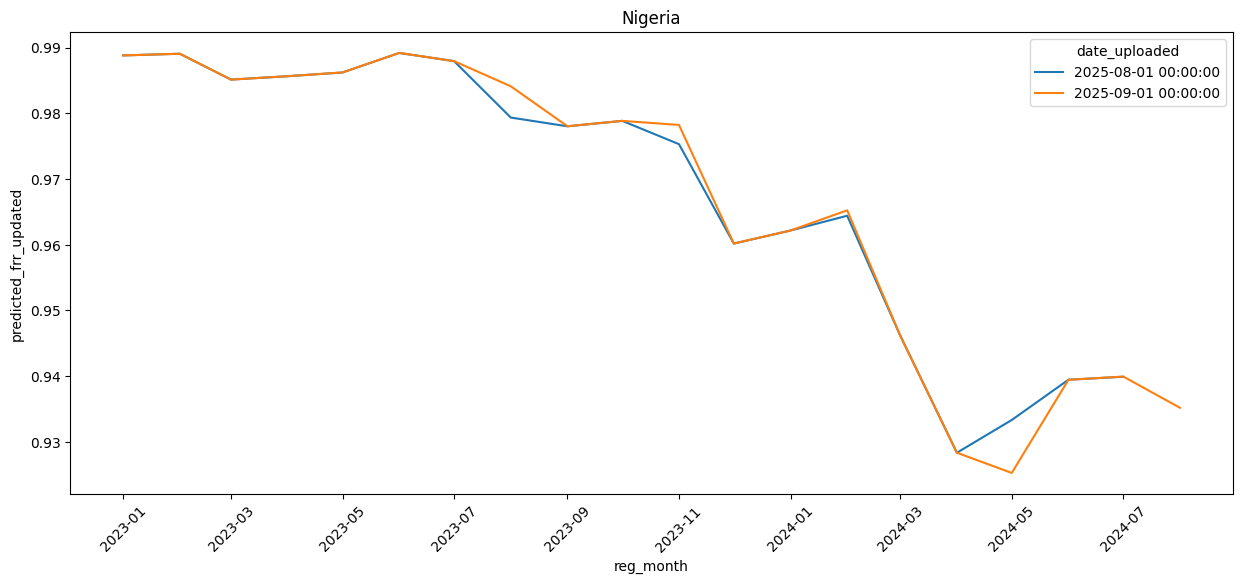

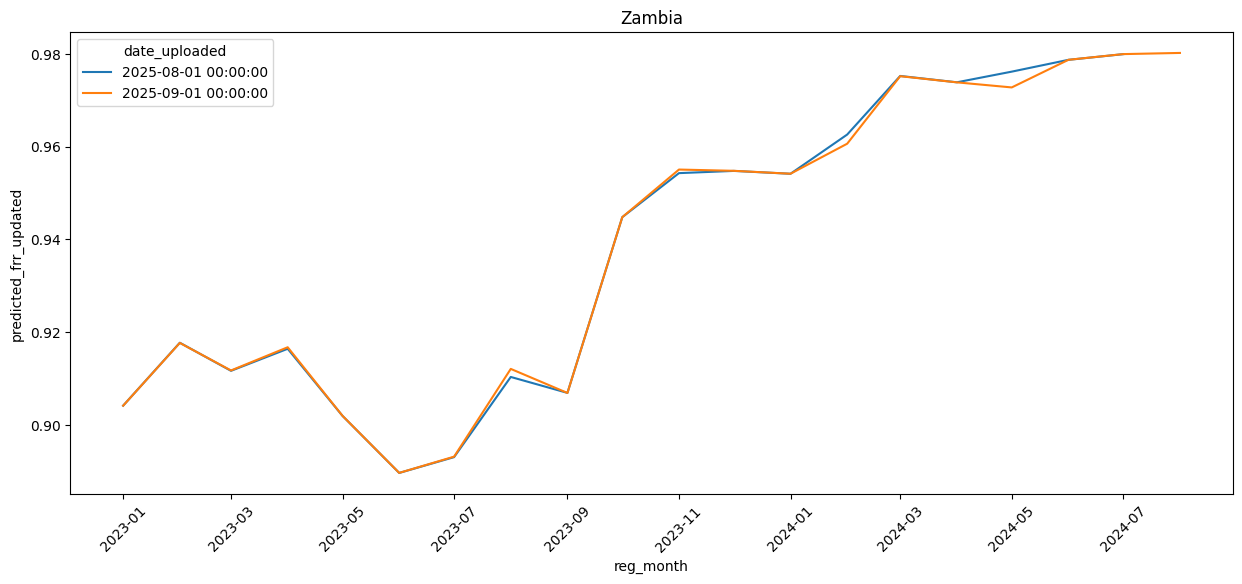

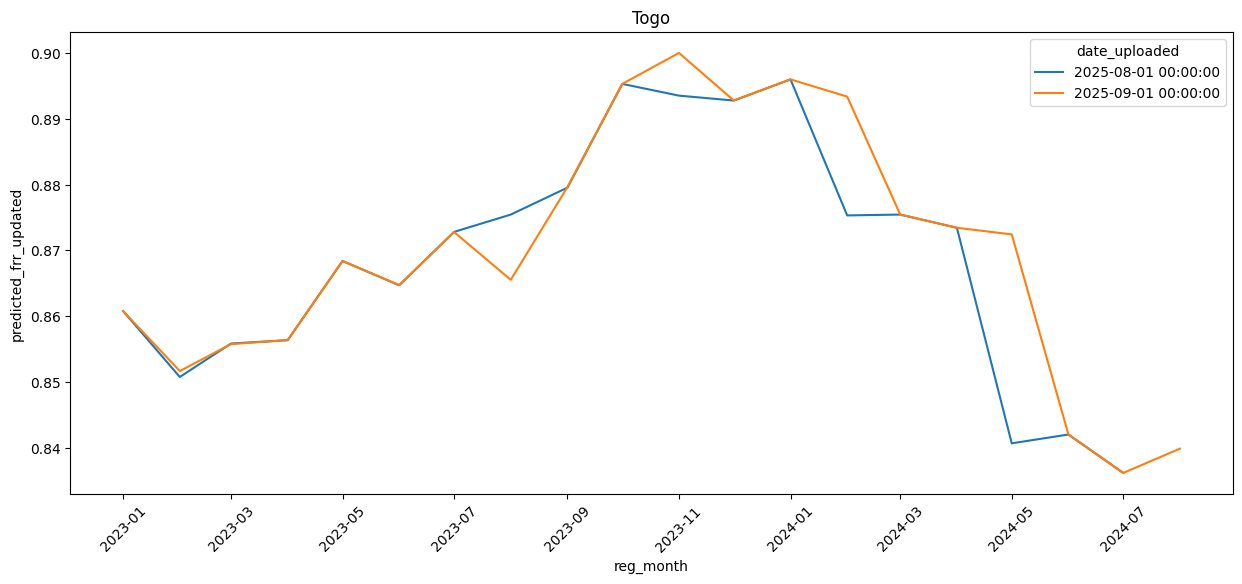

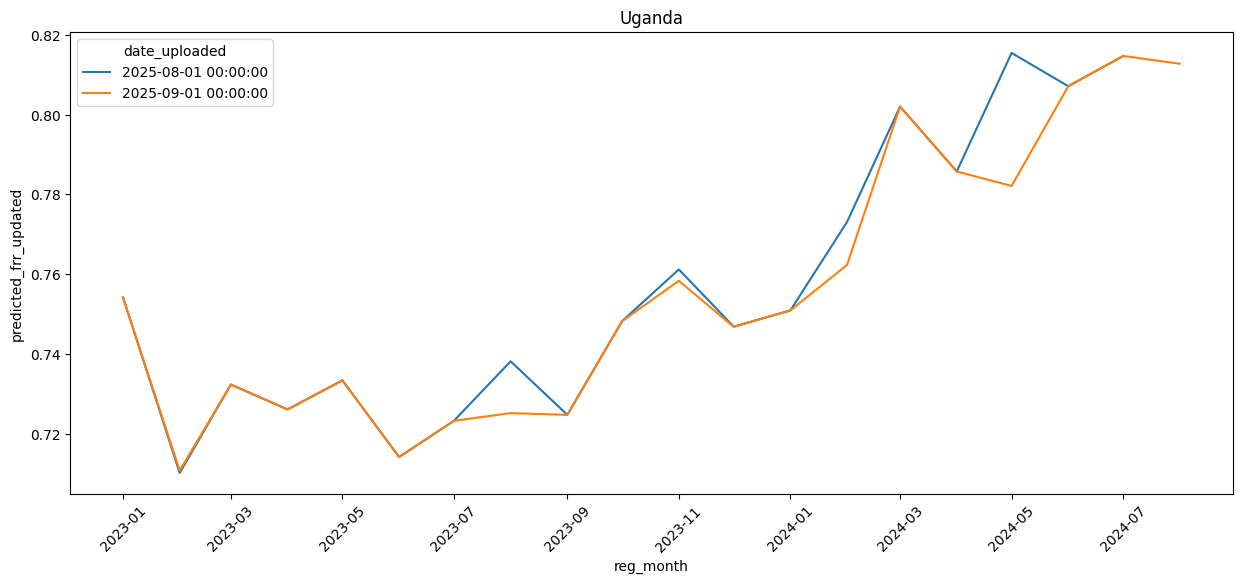

In [23]:
df_country = df.groupby(["country", "reg_month", "date_uploaded"]).agg(
    count_average=("count_units", lambda x: int(x.mean())),
    predicted_fr = ("predicted_revenue_3_years_50", "sum"),
    total_fr = ("total_follow_on_revenue_current_usd", "sum")
).reset_index()
df_country["predicted_frr_updated"] = df_country.predicted_fr/df_country.total_fr
df_country = df_country.drop(['total_fr', 'predicted_fr'], axis=1)
# products = ["Lanterns", "Phones", "SHS Entry-Level", "SHS with TV", "SHS without TV", "SHS Entry-Level Upgrade", "SHS with TV Upgrade"]
# df_country = df_country[df_country.product_group.isin(products)]
df_country

for country in ["Kenya", "Tanzania", "Nigeria", "Zambia", "Togo", "Uganda"]:
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=df_country[(df_country.country==country) & (df_country.reg_month>="2023-01-01")], x="reg_month", y="predicted_frr_updated",\
                  hue="date_uploaded")
    # sns.lineplot(data=df_country, x="reg_month", y="frr_prediction_50")
    plt.xticks(rotation=45)
    plt.title(country)
    plt.show()

In [24]:
df_country[df_country.country=="Kenya"]

,country,reg_month,date_uploaded,count_average,predicted_frr_updated
203,Kenya,2016-01-01,2025-08-01,57,0.972130
204,Kenya,2016-01-01,2025-09-01,57,0.972126
205,Kenya,2016-02-01,2025-08-01,152,0.959730
206,Kenya,2016-02-01,2025-09-01,152,0.959729
207,Kenya,2016-03-01,2025-08-01,77,0.946891
...,...,...,...,...,...
405,Kenya,2024-06-01,2025-08-01,61,0.857415
406,Kenya,2024-06-01,2025-09-01,61,0.857472
407,Kenya,2024-07-01,2025-08-01,58,0.854492
408,Kenya,2024-07-01,2025-09-01,58,0.854497


In [25]:
df_country[df_country["reg_month"]=="2024-05-01"]

,country,reg_month,date_uploaded,count_average,predicted_frr_updated
36,Cameroon,2024-05-01,2025-08-01,20,0.922957
37,Cameroon,2024-05-01,2025-09-01,20,0.914780
197,India,2024-05-01,2025-08-01,5,0.821970
198,India,2024-05-01,2025-09-01,5,0.816320
403,Kenya,2024-05-01,2025-08-01,73,0.857060
404,Kenya,2024-05-01,2025-09-01,73,0.841875
444,Malawi,2024-05-01,2025-08-01,106,0.976877
445,Malawi,2024-05-01,2025-09-01,106,0.974639
513,Mozambique,2024-05-01,2025-08-01,27,0.807415
514,Mozambique,2024-05-01,2025-09-01,27,0.787005


In [ ]:
kpi_processed_file = 'num2_KPIs_data_processed_2025-09-01.csv'
df_kpi = pd.read_csv(kpi_processed_file)
df_kpi = df_kpi[df_kpi['backtesting_limit'] == 360].reset_index().drop(columns = 'index')

In [ ]:
df_kpi.columns

Index(['accounts_group', 'reg_month', 'country', 'product_group', 'area',
       'primary_product', 'count_units', 'avg_planned_repayment_days',
       'total_follow_on_revenue_current_usd', 'total_follow_on_revenue',
       ...
       'frr_growth_180_270', 'frr_delta_360_270', 'frr_growth_270_360',
       'frr_delta_450_360', 'frr_growth_360_450', 'frr_delta_540_450',
       'frr_growth_450_540', 'frr_slope', 'frr_intercept', 'frr_ratio_90_360'],
      dtype='object', length=106)

In [ ]:
preds = model_reg_lgbm_qntl_tuned_pos_rmse.predict(df_kpi[model_reg_lgbm_qntl_tuned_pos_rmse.feature_name_])

In [ ]:
df_kpi["predictions"] = preds

In [ ]:
df_kpi[["frr_720", "predictions"]].sample(n=20)

,frr_720,predictions
55531,0.875132,0.907015
60617,0.738350,0.783437
31655,0.964286,0.980586
161242,NaN,0.991934
10205,1.000000,1.000656
60178,0.877765,0.925382
146022,NaN,0.878966
165317,NaN,0.950587
30882,0.807836,0.838074
56615,1.000000,1.000042


In [ ]:
df_kpi

,accounts_group,reg_month,country,product_group,area,primary_product,count_units,avg_planned_repayment_days,total_follow_on_revenue_current_usd,total_follow_on_revenue,total_follow_on_revenue_usd,frr_30,frr_60,frr_90,frr_180,frr_270,frr_360,frr_450,frr_540,frr_630,frr_720,repayment_speed_30,repayment_speed_60,repayment_speed_90,repayment_speed_180,repayment_speed_270,repayment_speed_360,repayment_speed_450,repayment_speed_540,repayment_speed_630,repayment_speed_720,avg_cum_days_disabled_30,avg_cum_days_disabled_60,avg_cum_days_disabled_90,avg_cum_days_disabled_180,avg_cum_days_disabled_270,avg_cum_days_disabled_360,avg_cum_days_disabled_450,avg_cum_days_disabled_540,avg_cum_days_disabled_630,avg_cum_days_disabled_720,at_risk_rate_30,at_risk_rate_60,at_risk_rate_90,at_risk_rate_180,at_risk_rate_270,at_risk_rate_360,at_risk_rate_450,at_risk_rate_540,at_risk_rate_630,...,disabled_gt_two_week_rate_450,disabled_gt_two_week_rate_540,disabled_gt_two_week_rate_630,disabled_gt_two_week_rate_720,unlocked_rate_30,unlocked_rate_60,unlocked_rate_90,unlocked_rate_180,unlocked_rate_270,unlocked_rate_360,unlocked_rate_450,unlocked_rate_540,unlocked_rate_630,unlocked_rate_720,disabled_rate_30,disabled_rate_60,disabled_rate_90,disabled_rate_180,disabled_rate_270,disabled_rate_360,disabled_rate_450,disabled_rate_540,disabled_rate_630,disabled_rate_720,age_in_months,exchange,total_follow_on_revenue_usd_cal,total_follow_on_revenue_usd_final,avg_upfront_price_usd,avg_unlock_price_usd,backtesting_limit,cohort_age_backtesting,frr_delta_60_30,frr_growth_30_60,frr_delta_90_60,frr_growth_60_90,frr_delta_180_90,frr_growth_90_180,frr_delta_270_180,frr_growth_180_270,frr_delta_360_270,frr_growth_270_360,frr_delta_450_360,frr_growth_360_450,frr_delta_540_450,frr_growth_450_540,frr_slope,frr_intercept,frr_ratio_90_360,predictions
0,2016-01_Kenya_Lanterns_Kakamega_Sun King Pro E...,2016-01,Kenya,Lanterns,Kakamega,Sun King Pro EasyBuy,57,77,1543.400856,199500.0,1418.445741,0.352180,0.626566,0.785424,0.888827,0.924767,0.935544,0.945594,0.963138,0.964892,0.971333,1.0718,0.8275,0.7854,0.8888,0.9247,0.9355,0.9455,0.9631,0.9648,0.9713,1.0,5.0,11.0,25.0,33.0,42.0,43.0,51.0,57.0,69.0,0.181818,0.080000,0.148148,0.125000,0.222222,0.250000,0.333333,0.166667,0.200000,...,0.105263,0.087719,0.087719,0.052632,0.035088,0.122807,0.526316,0.719298,0.842105,0.859649,0.894737,0.894737,0.912281,0.947368,0.263158,0.315789,0.368421,0.228070,0.157895,0.122807,0.105263,0.105263,0.087719,0.052632,115,152.85,1305.2012,1305.201200,7.0,30.0,360,720,0.274386,0.779107,0.158858,0.253538,0.103403,0.131652,0.035940,0.040435,0.010777,0.011654,0.010050,0.010742,0.017544,0.018553,0.000880,0.584845,0.839537,0.978737
1,2016-02_Kenya_Lanterns_Bungoma_Sun King Pro Ea...,2016-02,Kenya,Lanterns,Bungoma,Sun King Pro EasyBuy,18,77,487.389744,63000.0,447.930234,0.425714,0.686587,0.807381,0.849048,0.856984,0.856984,0.856984,0.856984,0.892698,0.903810,1.2956,0.9068,0.8073,0.8490,0.8569,0.8569,0.8569,0.8569,0.8926,0.9038,0.0,3.0,8.0,14.0,14.0,14.0,14.0,14.0,102.0,105.0,0.055556,0.062500,0.090909,0.166667,0.166667,0.166667,0.166667,0.166667,0.250000,...,0.333333,0.333333,0.166667,0.055556,0.000000,0.111111,0.388889,0.666667,0.666667,0.666667,0.666667,0.666667,0.777778,0.833333,0.277778,0.388889,0.444444,0.333333,0.333333,0.333333,0.333333,0.333333,0.222222,0.055556,114,152.85,412.1688,412.168800,7.0,30.0,360,720,0.260873,0.612789,0.120794,0.175934,0.041667,0.051608,0.007936,0.009347,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000533,0.642643,0.942119,0.903761
2,2016-02_Kenya_Lanterns_Kakamega_Sun King Pro E...,2016-02,Kenya,Lanterns,Kakamega,Sun King Pro EasyBuy,287,77,7771.158696,1004500.0,7141.998731,0.365668,0.618819,0.763085,0.867551,0.897489,0.917509,0.924428,0.933954,0.938175,0.951517,1.1129,0.8173,0.7630,0.8675,0.8974,0.9175,0.9244,0.9339,0.9381,0.9515,1.0,7.0,13.0,32.0,43.0,55.0,63.0,72.0,80.0,90.0,0.156364,0.113725,0.130435,0.166667,0.196721,0.224490,0.244444,0.263158,0.272727,...,0.1324

In [ ]:
df_kpi["date_uploaded"] = "2025-09-01"

In [ ]:
df_kpi["date_uploaded"] = pd.to_datetime(df_kpi["date_uploaded"], format="%Y-%m-%d")
df_kpi["reg_month"] = pd.to_datetime(df_kpi["reg_month"], format="%Y-%m")

In [ ]:
df_kpi["predicted_revenue_3_years_50"] = np.round(df_kpi['predictions']*df_kpi['total_follow_on_revenue_current_usd'],2)

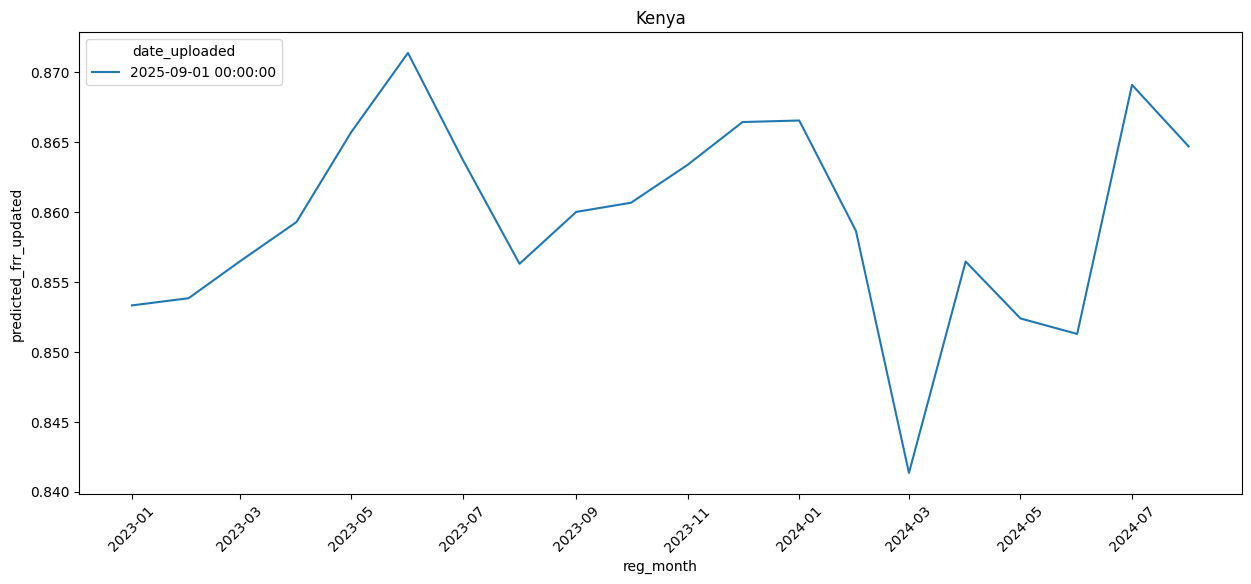

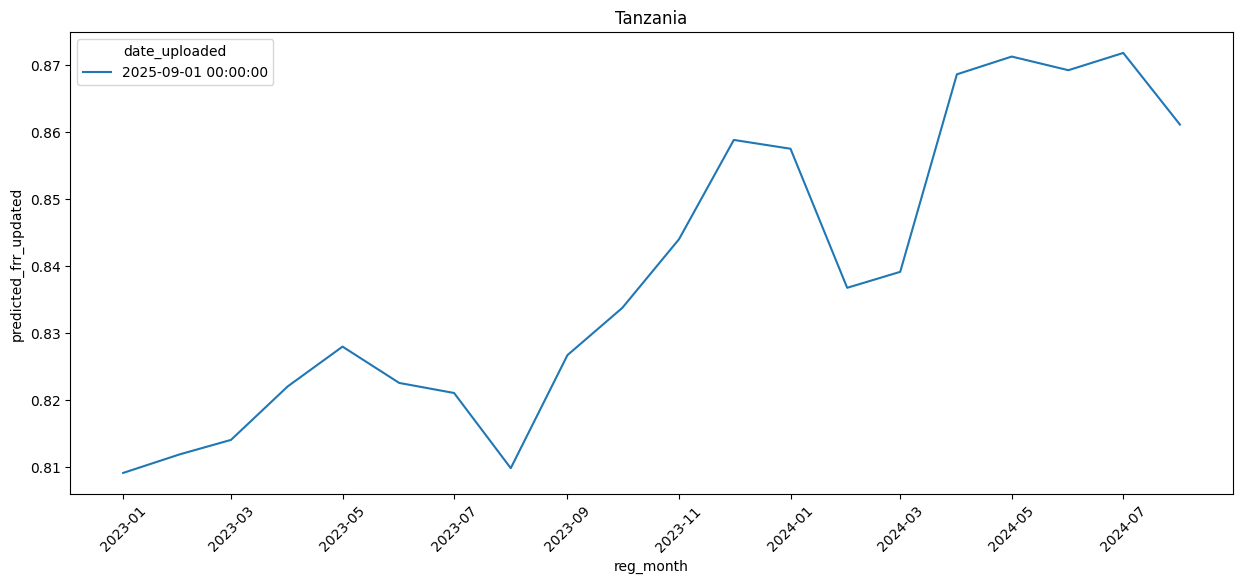

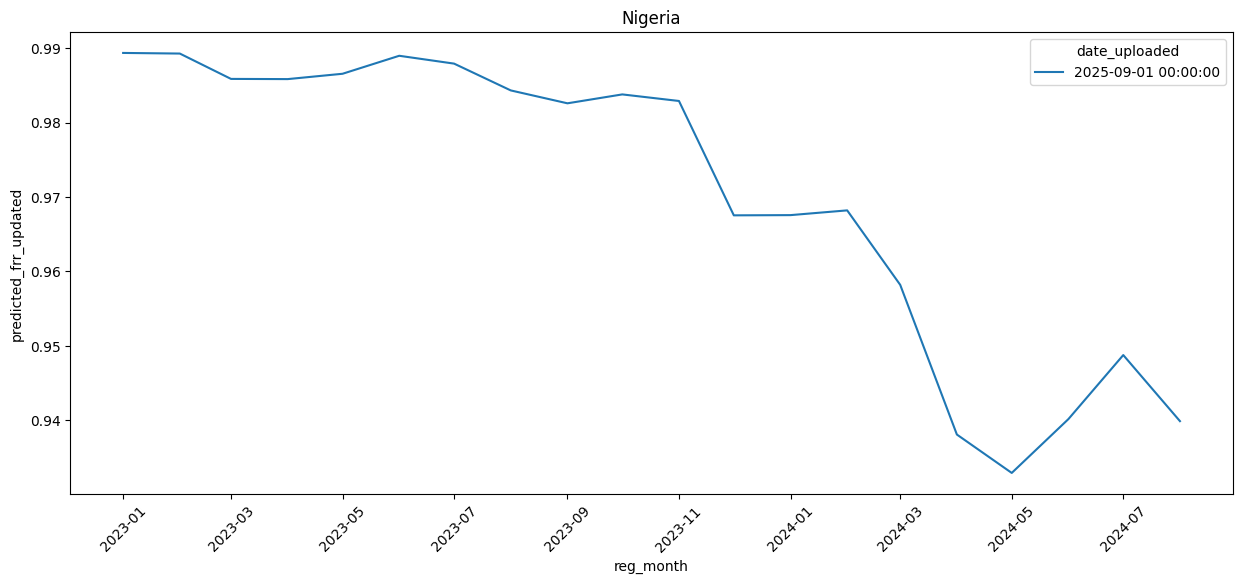

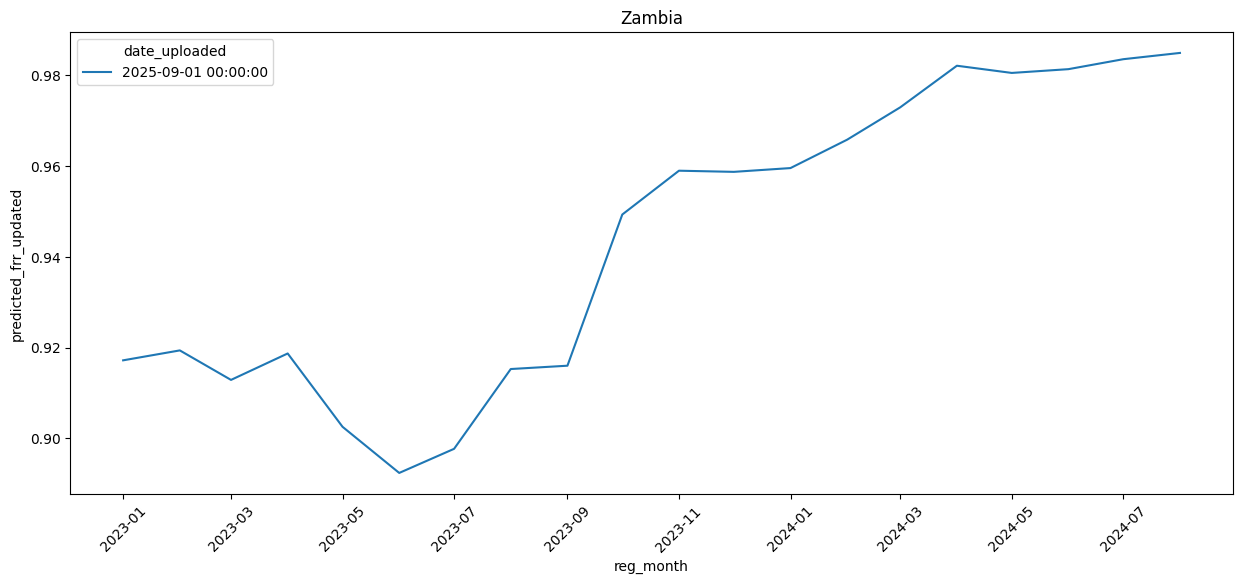

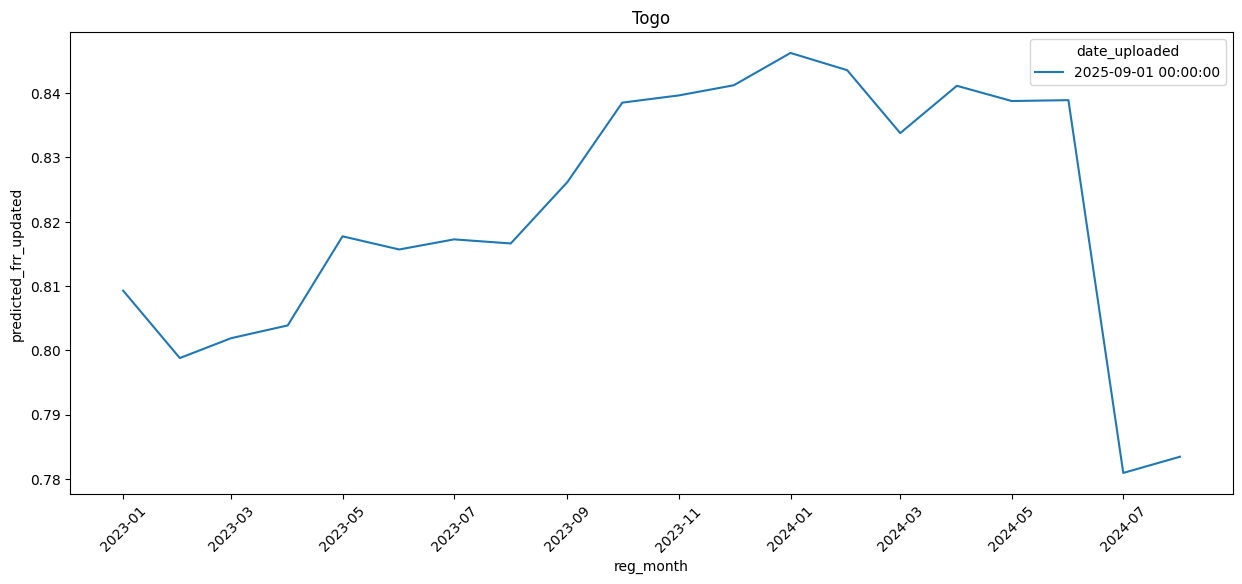

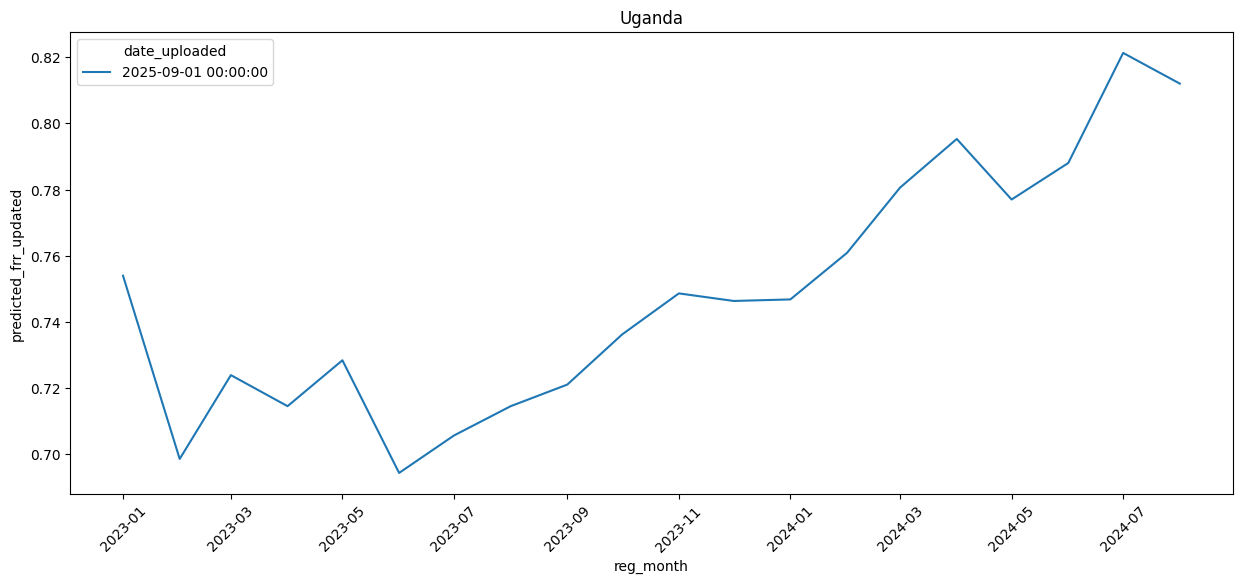

In [ ]:
df_country = df_kpi.groupby(["country", "reg_month", "date_uploaded"]).agg(
    count_average=("count_units", lambda x: int(x.mean())),
    predicted_fr = ("predicted_revenue_3_years_50", "sum"),
    total_fr = ("total_follow_on_revenue_current_usd", "sum")
).reset_index()
df_country["predicted_frr_updated"] = df_country.predicted_fr/df_country.total_fr
df_country = df_country.drop(['total_fr', 'predicted_fr'], axis=1)
# products = ["Lanterns", "Phones", "SHS Entry-Level", "SHS with TV", "SHS without TV", "SHS Entry-Level Upgrade", "SHS with TV Upgrade"]
# df_country = df_country[df_country.product_group.isin(products)]
df_country

for country in ["Kenya", "Tanzania", "Nigeria", "Zambia", "Togo", "Uganda"]:
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=df_country[(df_country.country==country) & (df_country.reg_month>="2023-01-01")], x="reg_month", y="predicted_frr_updated",\
                  hue="date_uploaded")
    # sns.lineplot(data=df_country, x="reg_month", y="frr_prediction_50")
    plt.xticks(rotation=45)
    plt.title(country)
    plt.show()

In [ ]:
df_country[df_country.country=="Kenya"].tail(30)

,country,reg_month,date_uploaded,count_average,predicted_frr_updated
176,Kenya,2022-03-01,2025-09-01,49,0.865376
177,Kenya,2022-04-01,2025-09-01,49,0.851400
178,Kenya,2022-05-01,2025-09-01,56,0.852331
179,Kenya,2022-06-01,2025-09-01,52,0.840885
180,Kenya,2022-07-01,2025-09-01,53,0.853413
181,Kenya,2022-08-01,2025-09-01,48,0.852162
182,Kenya,2022-09-01,2025-09-01,43,0.852957
183,Kenya,2022-10-01,2025-09-01,43,0.857030
184,Kenya,2022-11-01,2025-09-01,40,0.848252
185,Kenya,2022-12-01,2025-09-01,47,0.851843
